# Data Collection

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [6]:
df = pd.read_excel('premiums_rest.xlsx')
df.shape

(29904, 13)

In [7]:
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [8]:
df.columns


Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [9]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

# Handle missinng values

### Check for any null value if found any remove it

In [10]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### check for duplicates if found any use the function drop_duplicates to handle them

In [13]:
df.duplicated().sum()

0

In [14]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [15]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3])

In [16]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [17]:
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [18]:
# inorder to get the numeric columns from the df (in case there are too many)
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

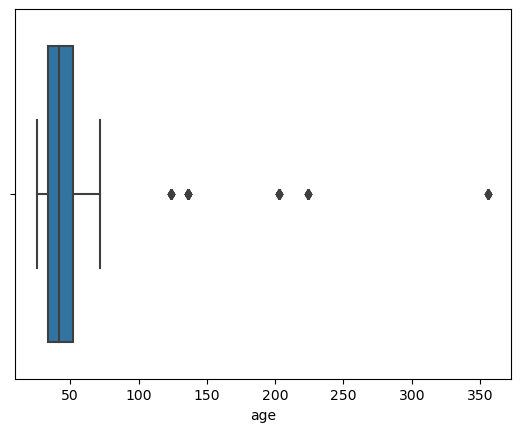

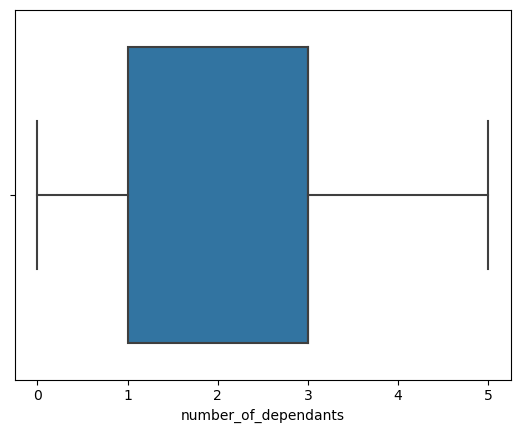

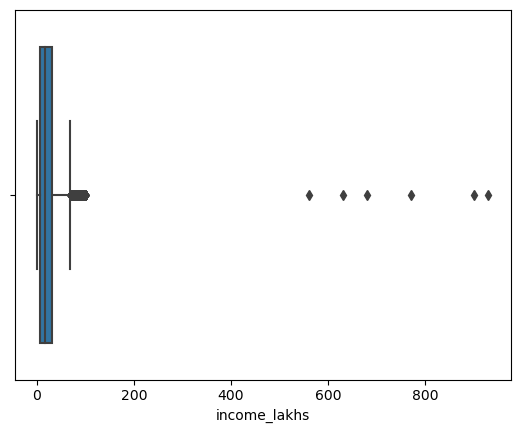

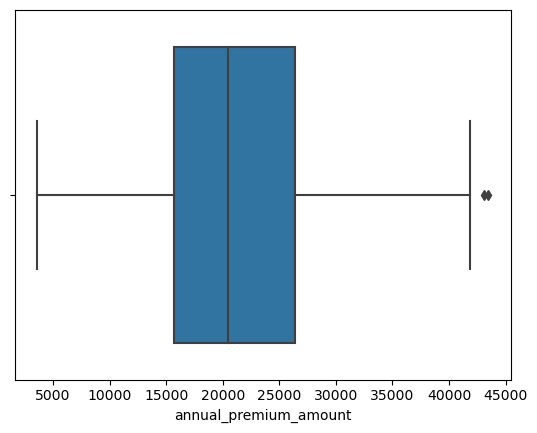

In [19]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [20]:
# here we can se that age and income_lakhs both have the outliers which need to be handled and 
#annual_premuim_amount has only two outliers which can be ignored

In [21]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [22]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


<AxesSubplot:xlabel='income_lakhs', ylabel='Count'>

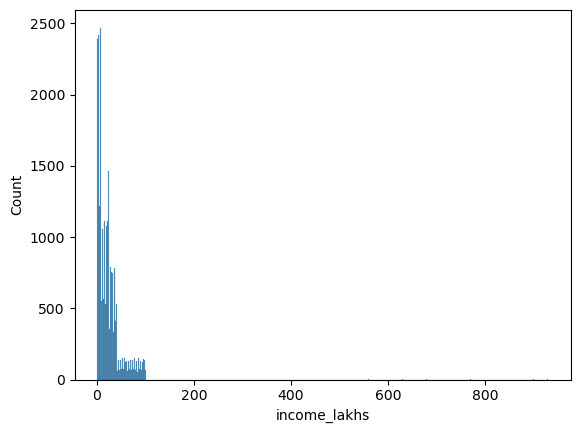

In [23]:
sns.histplot(df.income_lakhs)

In [24]:
#we use IQR methodlogy to handle the income_lakhs featture

In [25]:
def iqr(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    return lower_bound,upper_bound

In [26]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [27]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


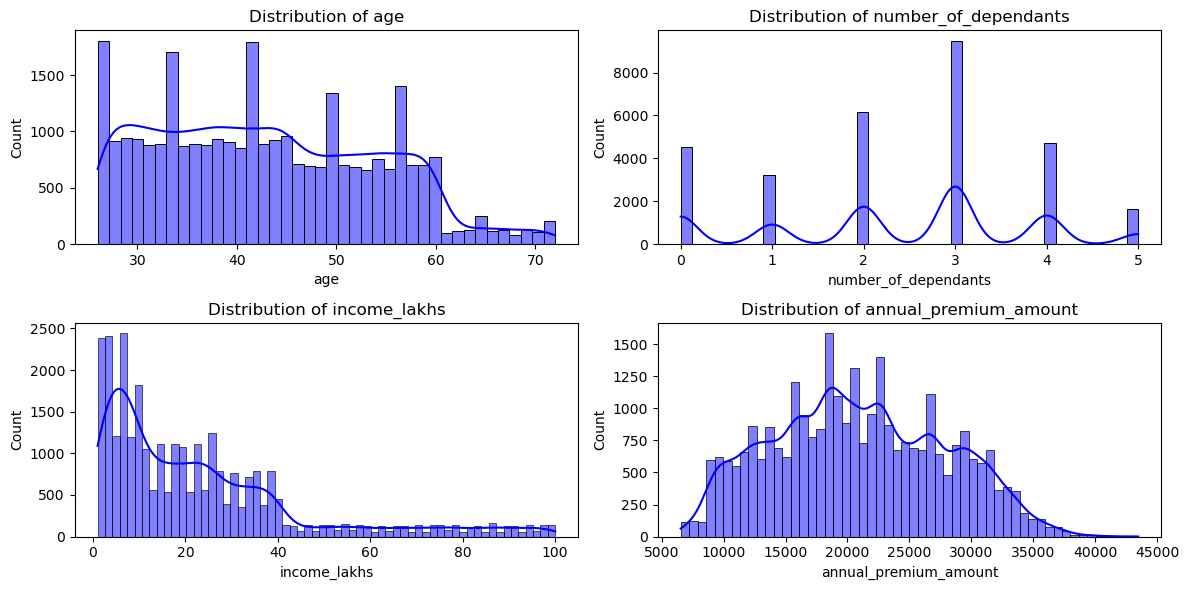

In [28]:
rows, cols = 2, 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))  

for i in range(0, len(numeric_columns), 2):
    row_index = i // cols

    for col_index in range(cols):
        if i + col_index < len(numeric_columns):
            col = numeric_columns[i + col_index]
            sns.histplot(df2[col], kde=True, color='blue', ax=axes[row_index, col_index])
            axes[row_index, col_index].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

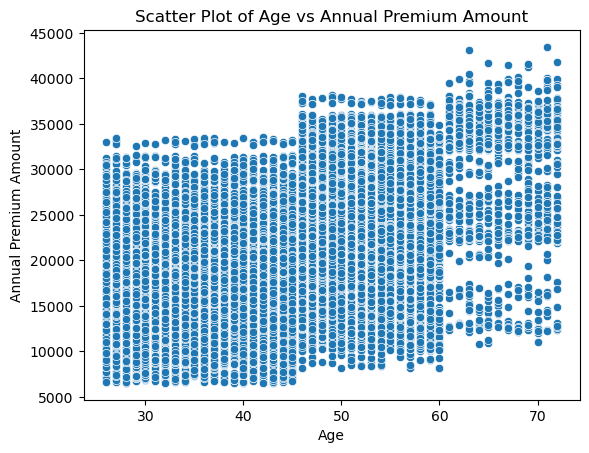

In [29]:
sns.scatterplot(x='age', y='annual_premium_amount', data=df2)
plt.title('Scatter Plot of Age vs Annual Premium Amount')
plt.xlabel('Age')
plt.ylabel('Annual Premium Amount')
plt.show()

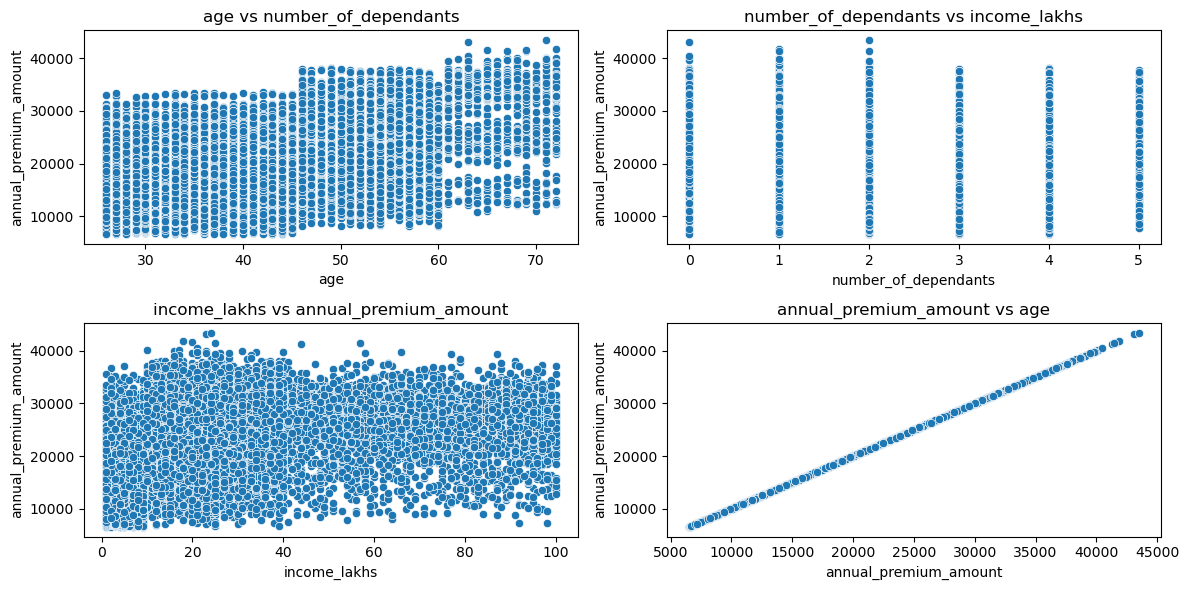

In [30]:
rows, cols = 2, 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))  

for i in range(0, len(numeric_columns), 2):
    row_index = i // cols


    for col_index in range(cols):
        if i + col_index < len(numeric_columns):
            col1 = numeric_columns[i + col_index]
            col2 = numeric_columns[(i + col_index + 1) % len(numeric_columns)]
            sns.scatterplot(x=df2[col1], y=df2['annual_premium_amount'], ax=axes[row_index, col_index])
            axes[row_index, col_index].set_title(f'{col1} vs {col2}')

plt.tight_layout()
plt.show()

### Categorical features

In [31]:
df2.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
dtype: object

In [32]:
categorical_cols = df2.select_dtypes('object')
categorical_cols.columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [33]:
for col in categorical_cols:
    print(col,df2[col].unique())

gender ['Male' 'Female']
region ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status ['Unmarried' 'Married']
bmi_category ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status ['Salaried' 'Self-Employed' 'Freelancer']
income_level ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan ['Bronze' 'Silver' 'Gold']


In [34]:
#here as you can see in the smoking status people have given smoking = 0 and does not smoke and not smoking values
#which are similar as no smoking so it is better to replace it as not smoking itself

In [35]:
df2['smoking_status'].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
},inplace=True)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [36]:
pct_gender=df2['gender'].value_counts(normalize=True)

<AxesSubplot:>

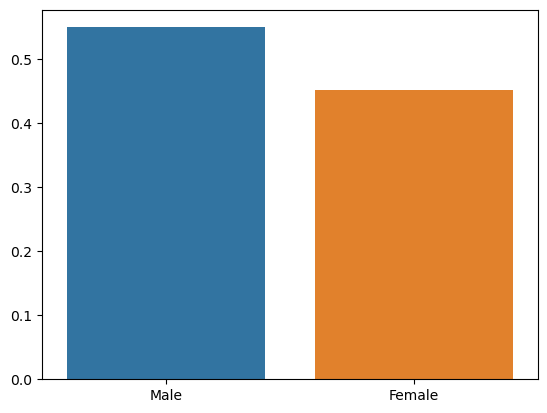

In [37]:
sns.barplot(x=pct_gender.index,y=pct_gender.values)

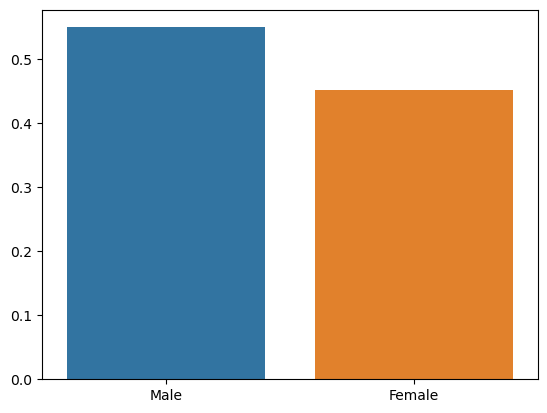

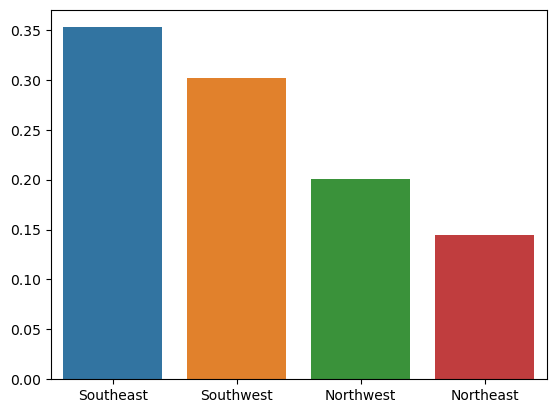

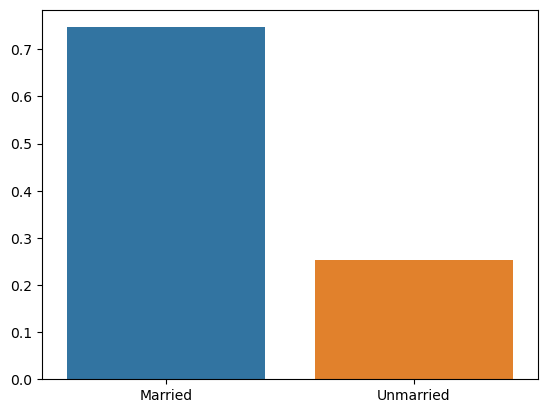

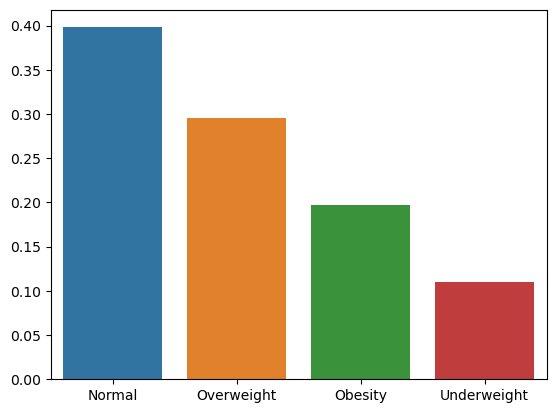

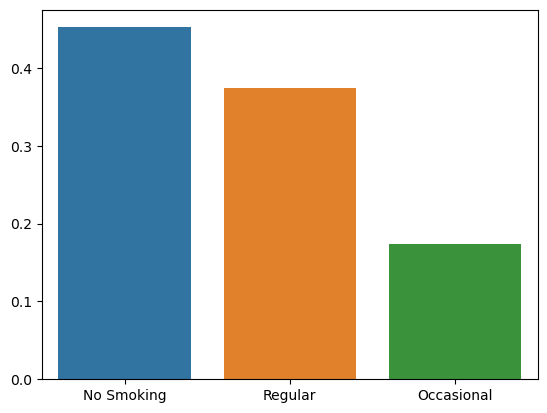

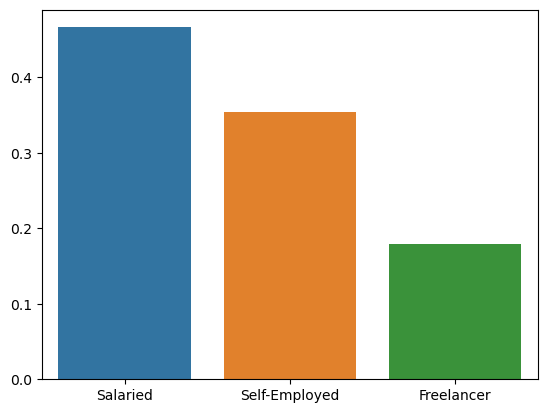

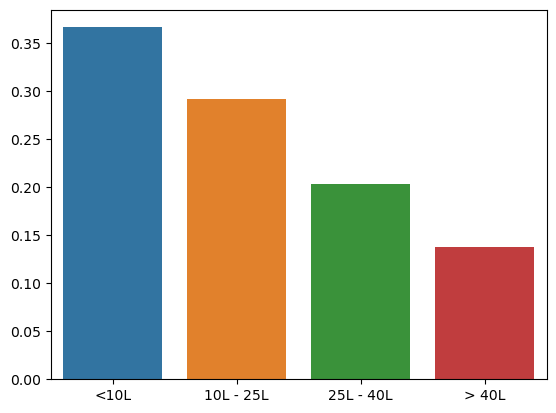

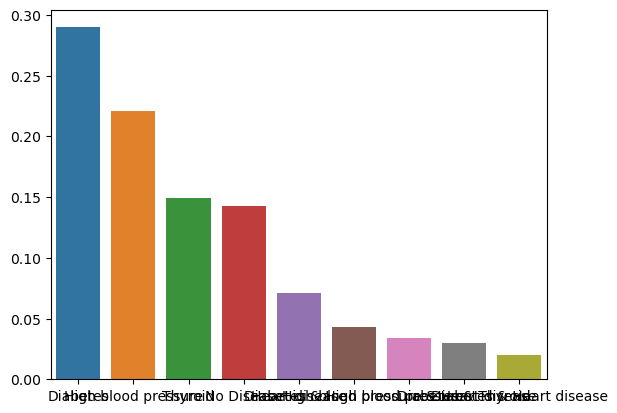

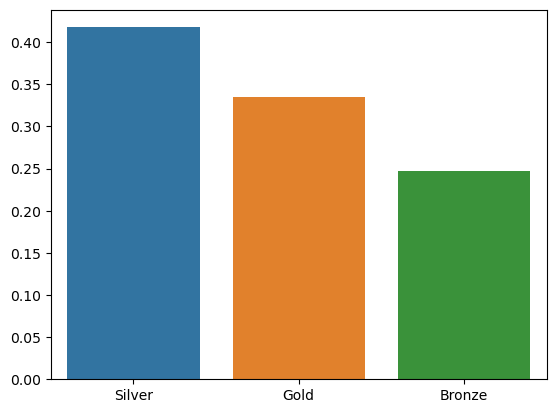

In [38]:
for col in categorical_cols:
    category_counts = df2[col].value_counts(normalize=True)
    sns.barplot(x=category_counts.index , y = category_counts.values)
    plt.show()

# Bi-variate analysis
### this means analyzing with two variables

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


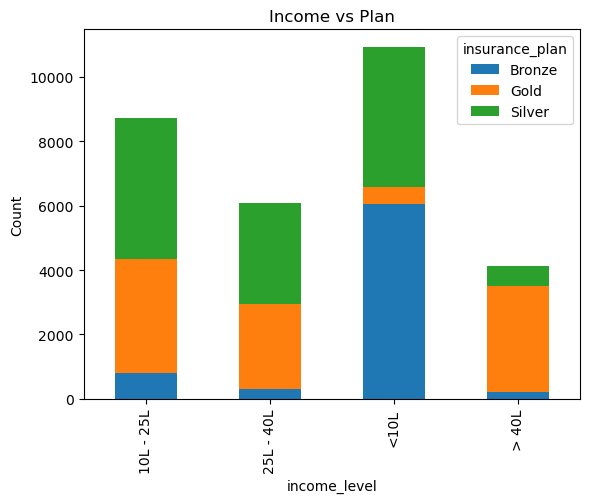

In [39]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar',stacked = True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()


<AxesSubplot:xlabel='insurance_plan', ylabel='income_level'>

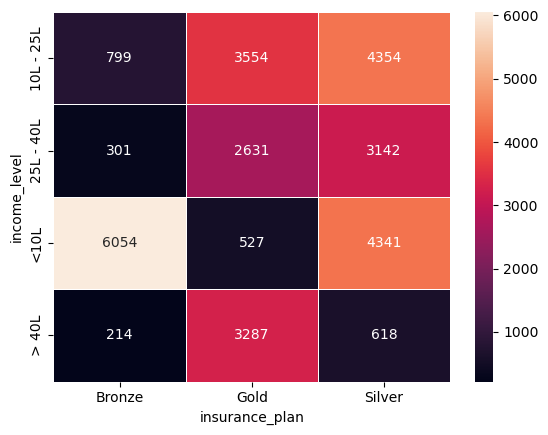

In [40]:
sns.heatmap(crosstab,annot=True,fmt='d',linewidths=.5)

## Feature Engineering

In [41]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [42]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [43]:
# here we are calculating the risk score for the medical history and usually provided by the buisness people
# with the risk score we will calculate the medical risk score because machinnes cannot process soo much text 
# which contains in the medical_history feature

In [44]:
risk_score = {
    'diabetes' : 6,
    'heart disease' : 8,
    'high blood pressure' : 6,
    'thyroid' : 5,
    'no disease' : 0,
    'none' : 0
 }



In [45]:
df2[['disease1','disease2']] = df['medical_history'].str.split(" & ",expand = True).apply(lambda x : x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None


In [46]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

for val in ['disease1','disease2']:
    df2['total_risk_score'] += df2[val].map(risk_score)
    
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalised_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head()


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalised_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6,0.428571


In [47]:
ordinal_mapping = {'Bronze': 1, 'Silver': 2, 'Gold': 3}

df2['insurance_plan'] = df2['insurance_plan'].map(ordinal_mapping)
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalised_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,1,15610,diabetes,none,6,0.428571


In [48]:
df2.insurance_plan.unique()

array([1, 2, 3])

In [49]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [50]:
ordinal_mapping2 = {'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4}

df2['income_level'] = df2['income_level'].map(ordinal_mapping2)
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalised_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,diabetes,none,6,0.428571


In [51]:
nominal_cols = ['gender','region','marital_status','bmi_category','smoking_status','employment_status']
df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)

In [52]:
df3.shape

(29822, 23)

In [53]:
df4 = df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


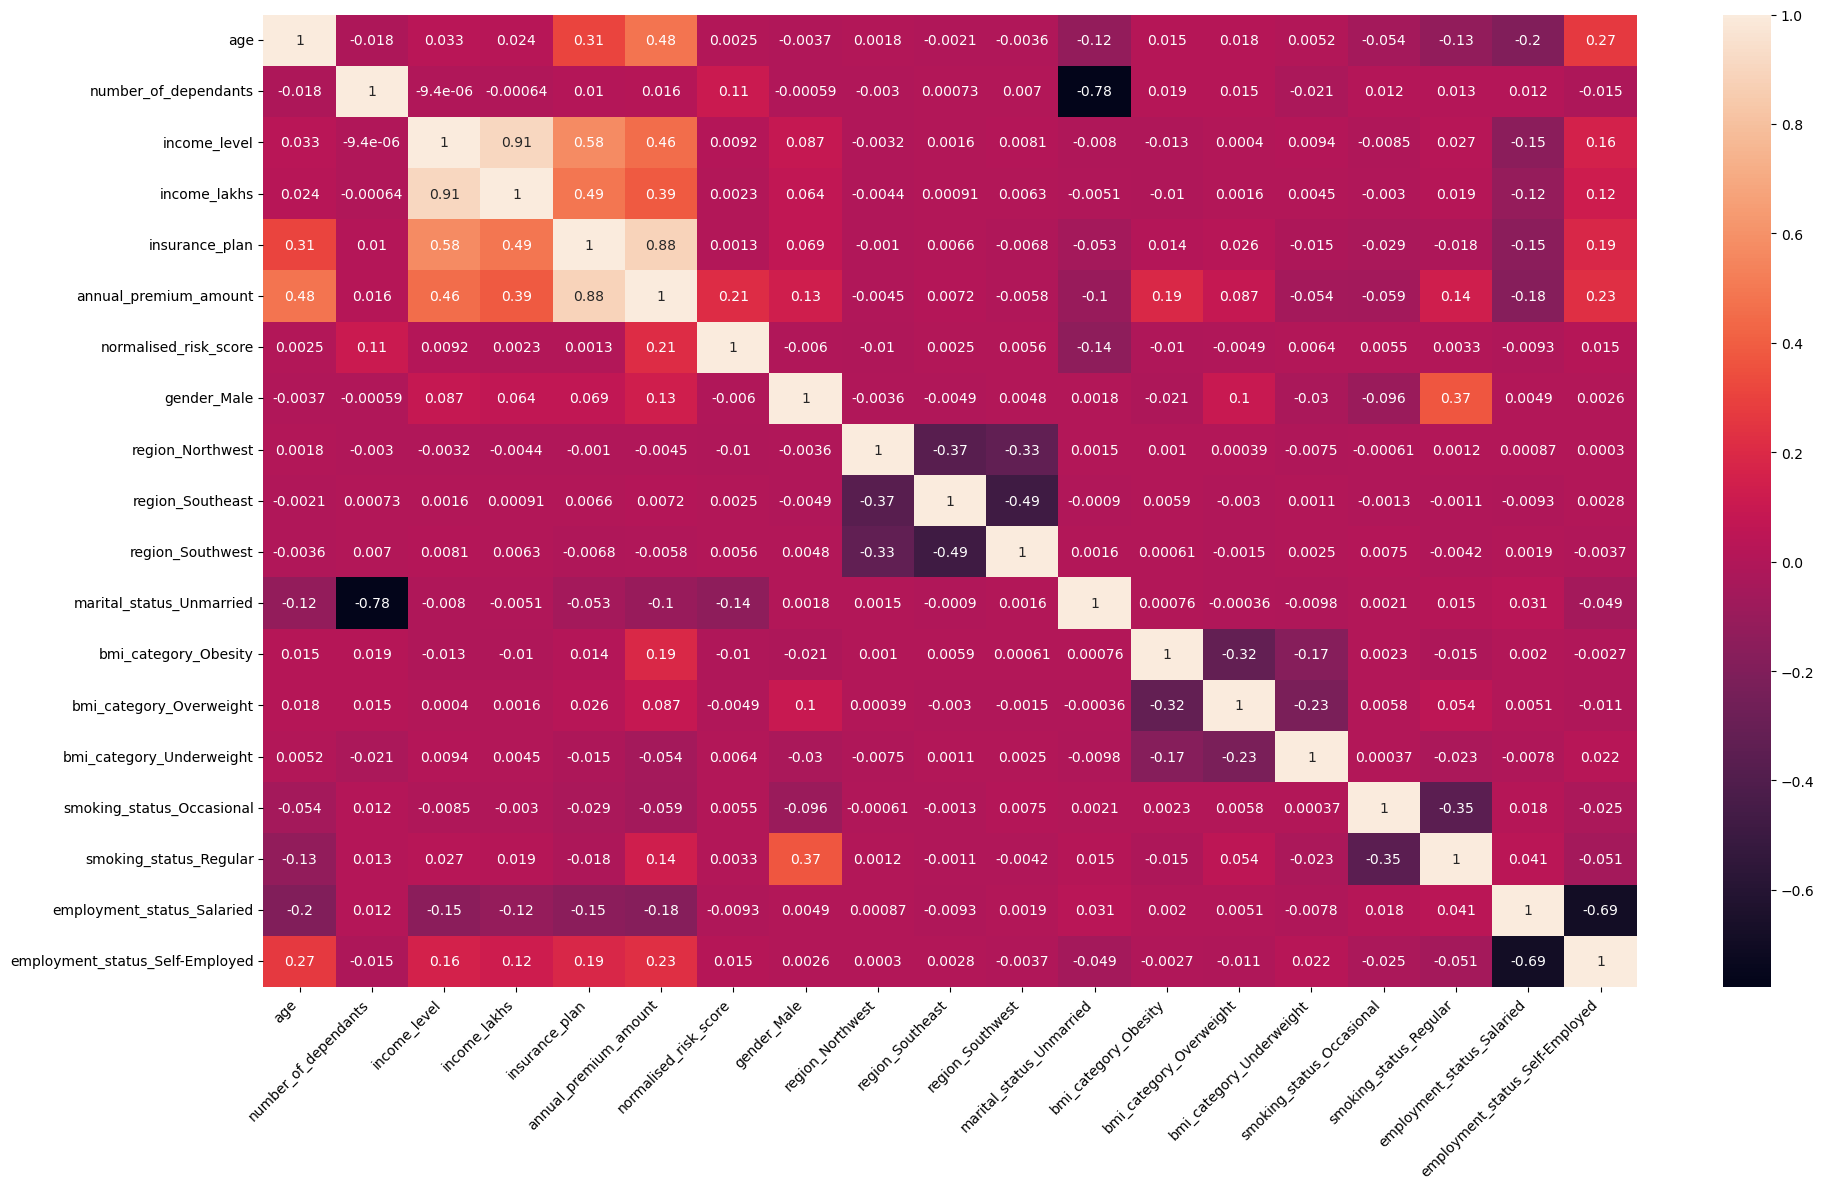

In [54]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [55]:
X = df4.drop('annual_premium_amount',axis = 'columns')
y = df4['annual_premium_amount']

cols_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
scaler = MinMaxScaler()

X[cols_scale] = scaler.fit_transform(X[cols_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [56]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [57]:
calculate_vif(X)

,column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalised_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [58]:
# as you can see vif is greater than 10 for two columns for the next iteration drop any one and calculate vif again

In [59]:
calculate_vif(X.drop('income_level',axis =1))

,column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalised_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [60]:
X_reduced = X.drop('income_level',axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


# Model Training

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [62]:
# Linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
model_lr.score(X_test,y_test)

0.9539009654285697

In [63]:
model_lr.coef_

array([ 6982.64001765, -1313.1090829 ,  -414.37130409,  -187.87781849,
       14908.14261863,  6057.35585396,    43.35812684,   -52.76407712,
         -17.8038548 ,   -19.45771109,  -701.41871643,  3924.48720299,
        1977.32876982,   615.89864182,   837.02259505,  2802.45871967,
         -54.0146376 ,   247.81401635])

In [64]:
model_lr.intercept_

5942.728717538455

In [65]:
feature_importance = model_lr.coef_
coef_df = pd.DataFrame(feature_importance,index = X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
number_of_dependants,-1313.109083
marital_status_Unmarried,-701.418716
income_level,-414.371304
income_lakhs,-187.877818
employment_status_Salaried,-54.014638
region_Northwest,-52.764077
region_Southwest,-19.457711
region_Southeast,-17.803855
gender_Male,43.358127
employment_status_Self-Employed,247.814016


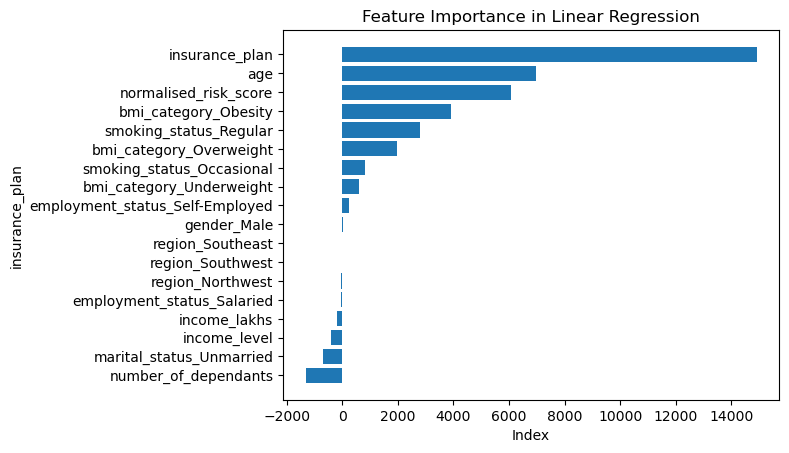

In [66]:
plt.barh(coef_df.index, coef_df['Coefficients'])
plt.title('Feature Importance in Linear Regression')
plt.xlabel('Index')
plt.ylabel(col)
plt.show()

In [67]:
#Ridge Model 
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train,y_train)
ridge_model.score(X_test,y_test)


0.953902278229871

In [68]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_model.score(X_test,y_test)


0.997699478122133

In [69]:
#XG BOOST regression model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train,y_train)
xgb_model.score(X_test,y_test)

0.9980926368604903

# Fine Tuning

In [70]:
#In order to find the best hyperparameters we will use randomisedCV
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators' : [20,40,60,80],
    'learning_rate' : [0.01,0.5,0.75,0.1],
    'max_depth' : [3,4,5,6]
}
random_search = RandomizedSearchCV(estimator=model_xgb,param_distributions=param_grid,n_iter=10,cv=5,random_state=42)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Best Parameters: {'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.5}
Mean Squared Error: 95243.32438612248
R-squared: 0.9979870495974339


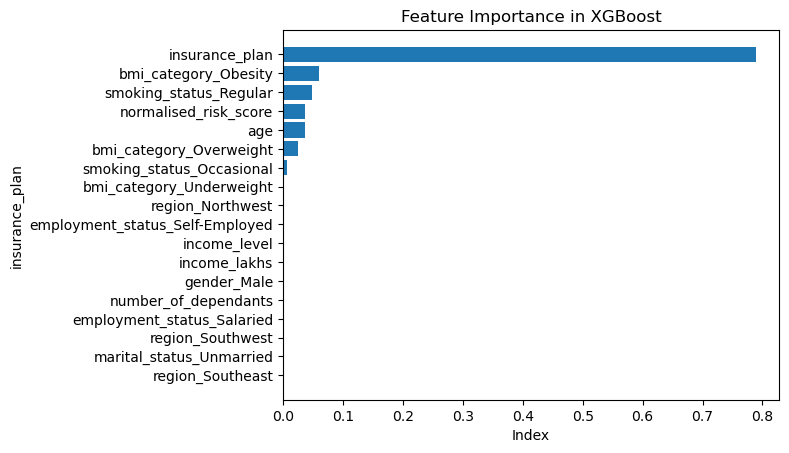

In [71]:
# Plotting a feature importances bar chart for xgboost model
feature_importance = best_rf_model.feature_importances_
coef_df = pd.DataFrame(feature_importance,index = X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.barh(coef_df.index, coef_df['Coefficients'])
plt.title('Feature Importance in XGBoost')
plt.xlabel('Index')
plt.ylabel(col)
plt.show()

# Error Analysis

In [72]:
y_pred = best_rf_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual' : y_test,
    'predicted' : y_pred,
    'diff' : residuals,
    'diff_pct' : residuals_pct
})

results_df

,actual,predicted,diff,diff_pct
19713,26895,26600.431641,-294.568359,-1.095253
14750,22734,23104.507812,370.507812,1.629752
19932,21198,21494.417969,296.417969,1.398330
29643,9100,9086.196289,-13.803711,-0.151689
17076,26434,26615.800781,181.800781,0.687754
...,...,...,...,...
3387,9291,9073.455078,-217.544922,-2.341459
7858,18261,18113.054688,-147.945312,-0.810171
9744,12419,12130.999023,-288.000977,-2.319035
4849,29735,29559.496094,-175.503906,-0.590227


<AxesSubplot:xlabel='diff_pct', ylabel='Count'>

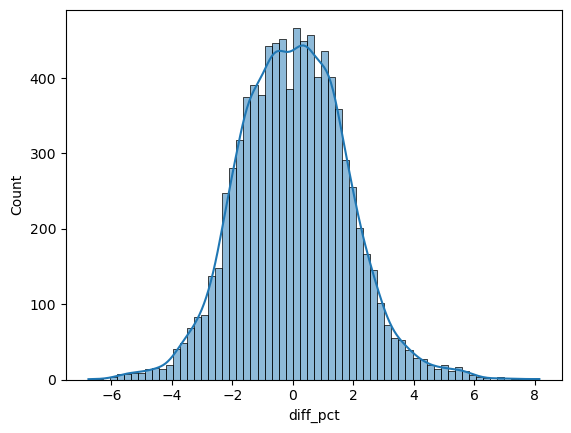

In [73]:
sns.histplot(results_df['diff_pct'],kde = True)

In [74]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(0, 4)

In [75]:
results_df.shape

(8947, 4)

In [76]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.0

In [77]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct',ascending=False)

,actual,predicted,diff,diff_pct


In [78]:
X_test.index

Int64Index([19713, 14750, 19932, 29643, 17076, 20314, 24893, 26722, 25844,
            10731,
            ...
            10637,  1224, 17046, 19228,  9275,  3387,  7858,  9744,  4849,
             8986],
           dtype='int64', length=8947)

In [79]:
extreme_results_df.index

Int64Index([], dtype='int64')

In [80]:
extreme_error_df = X_test.loc[extreme_results_df.index]
extreme_error_df.head(10)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed


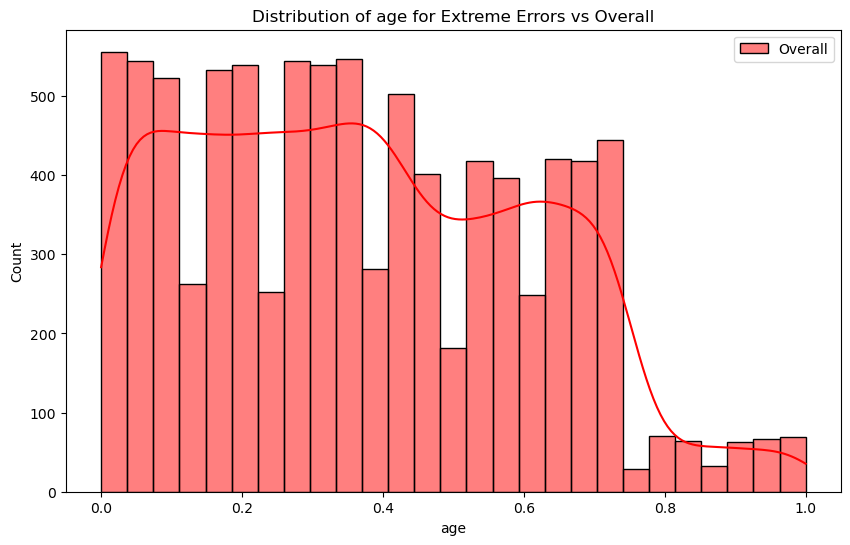

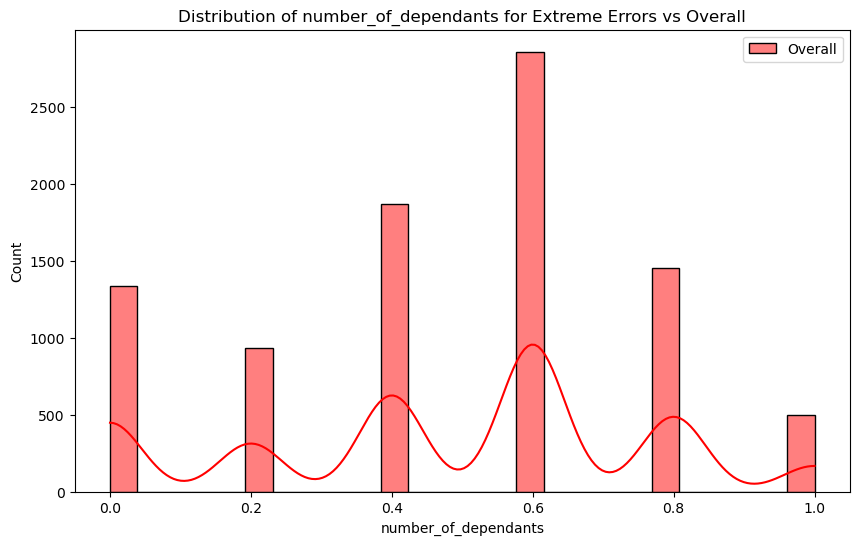

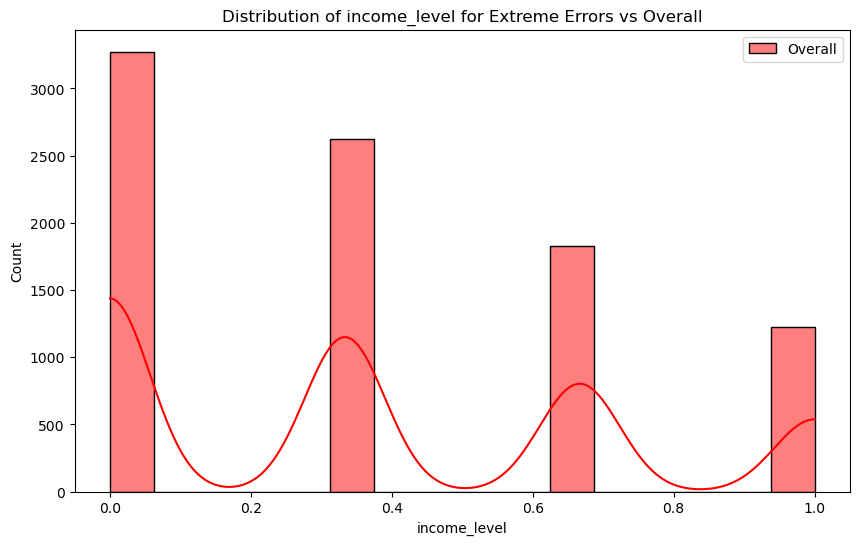

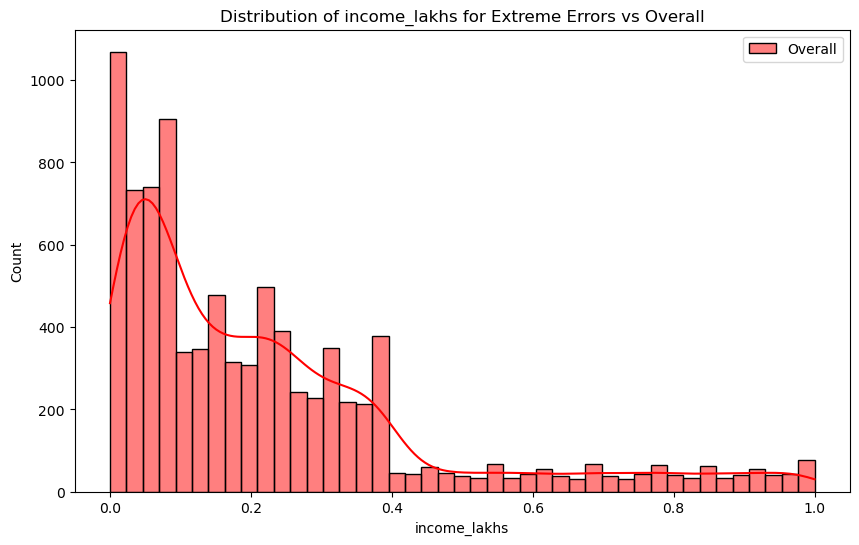

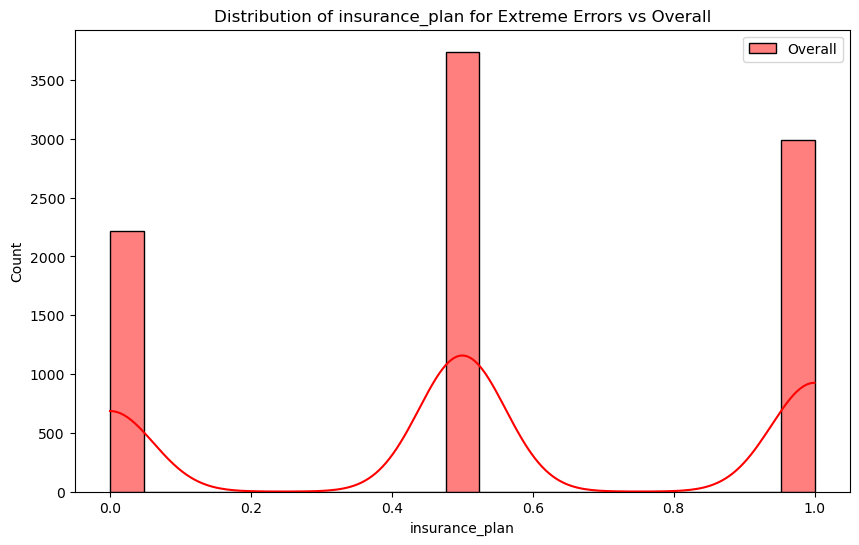

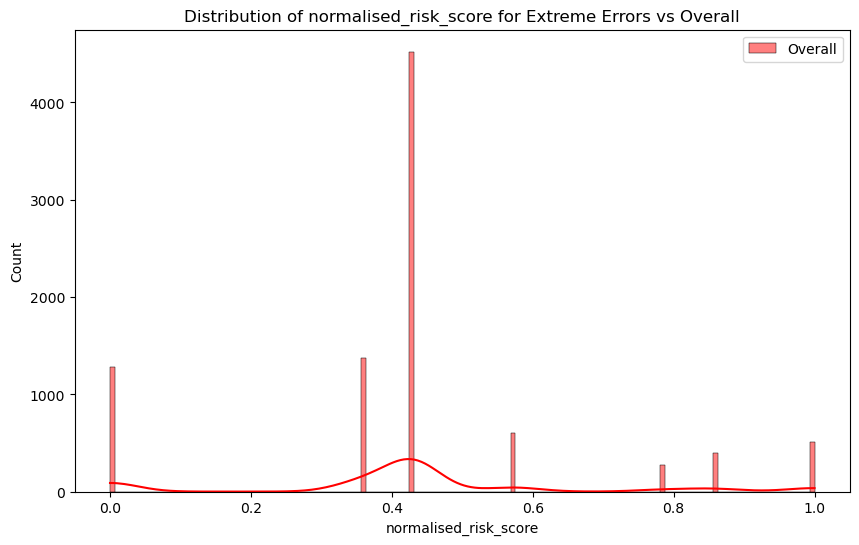

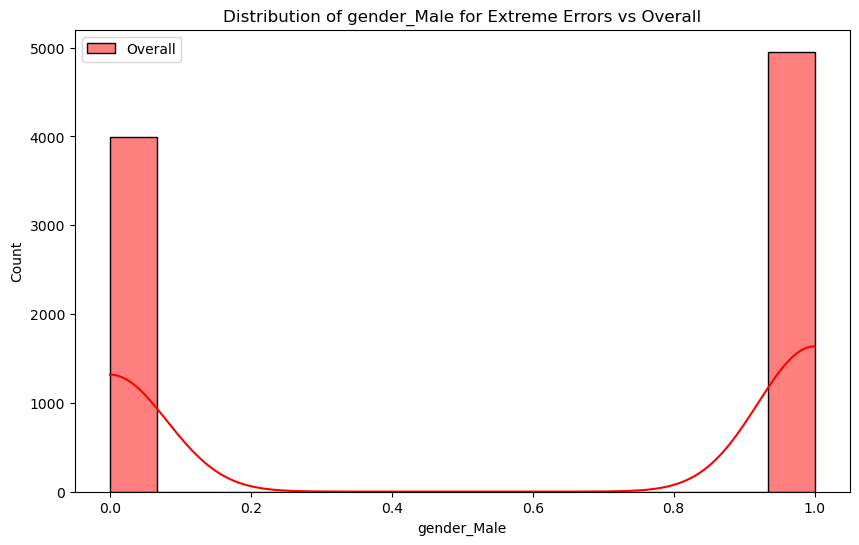

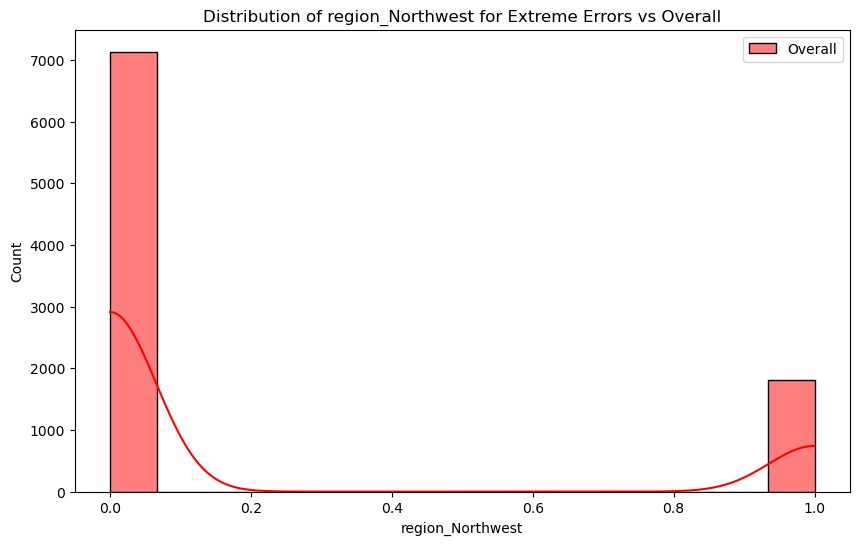

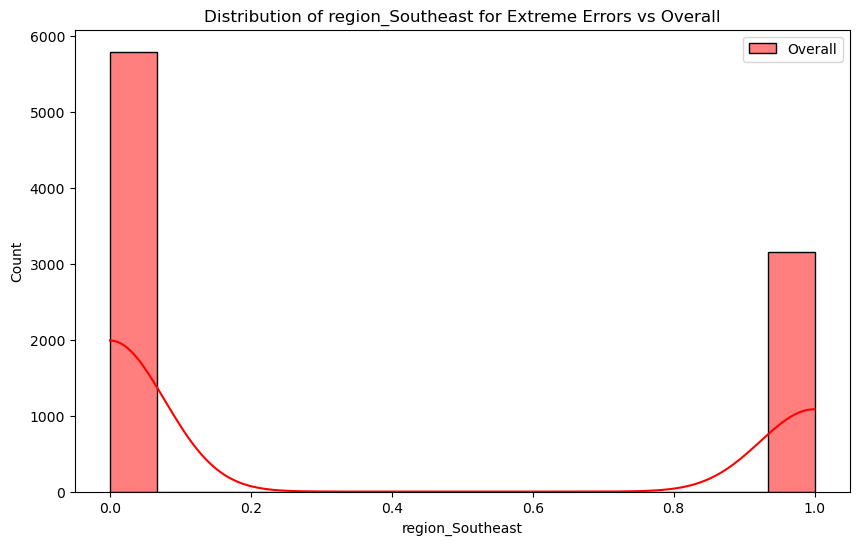

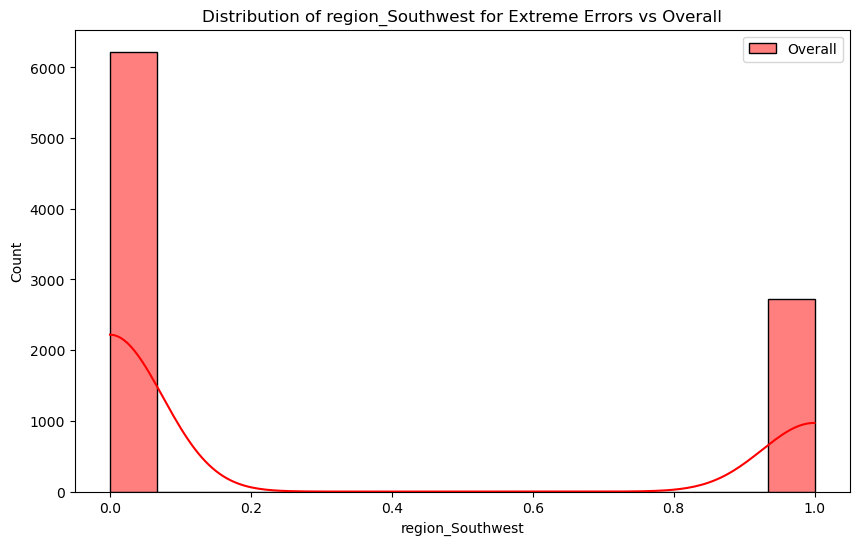

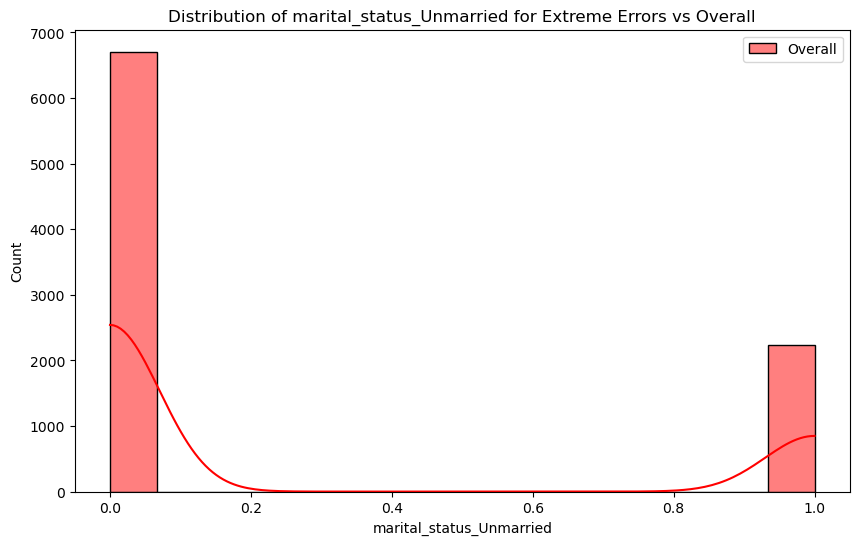

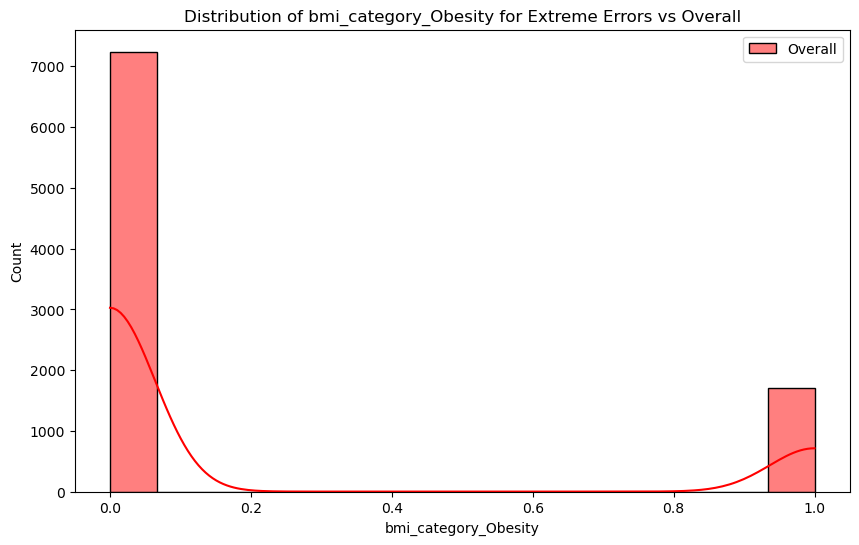

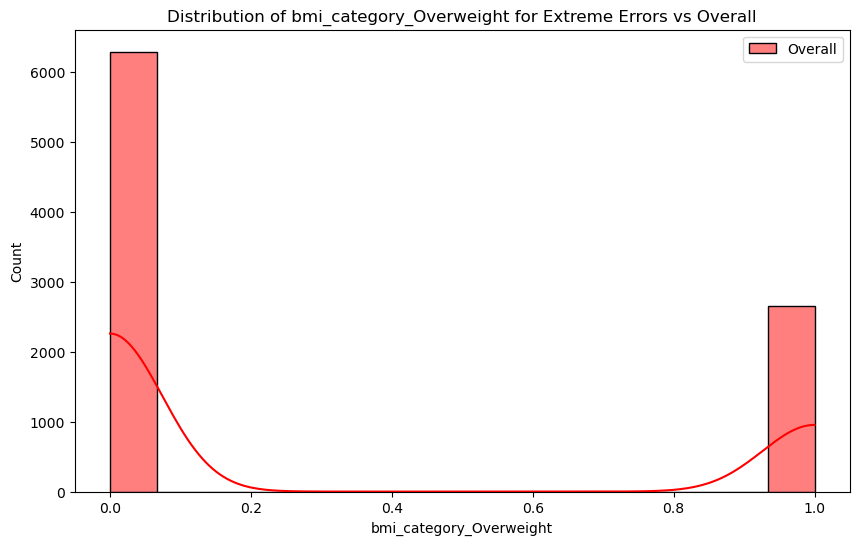

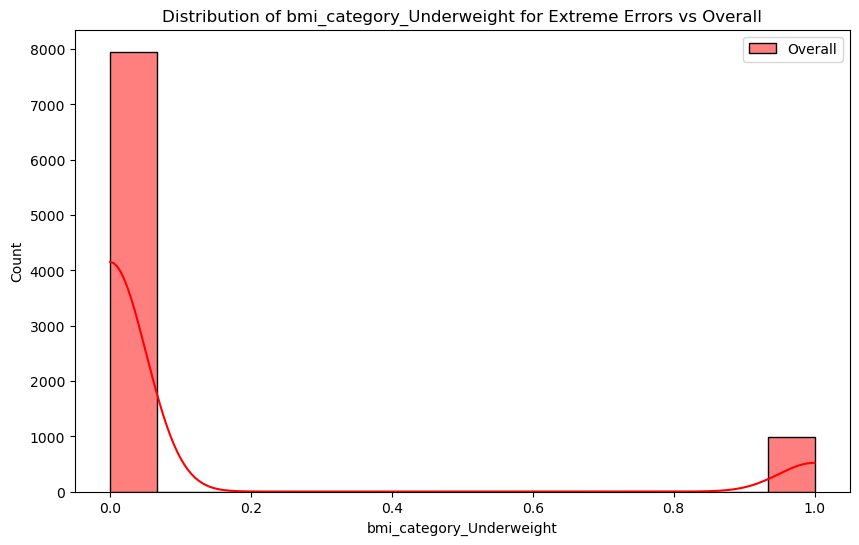

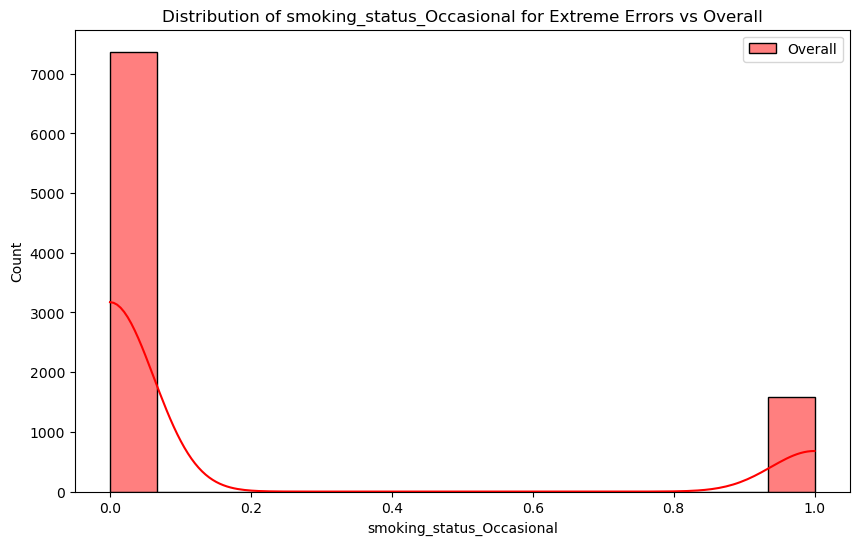

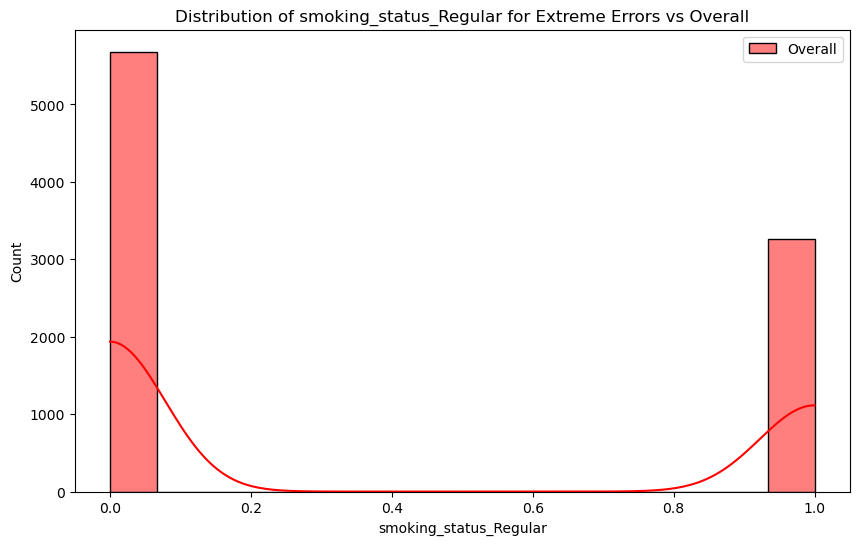

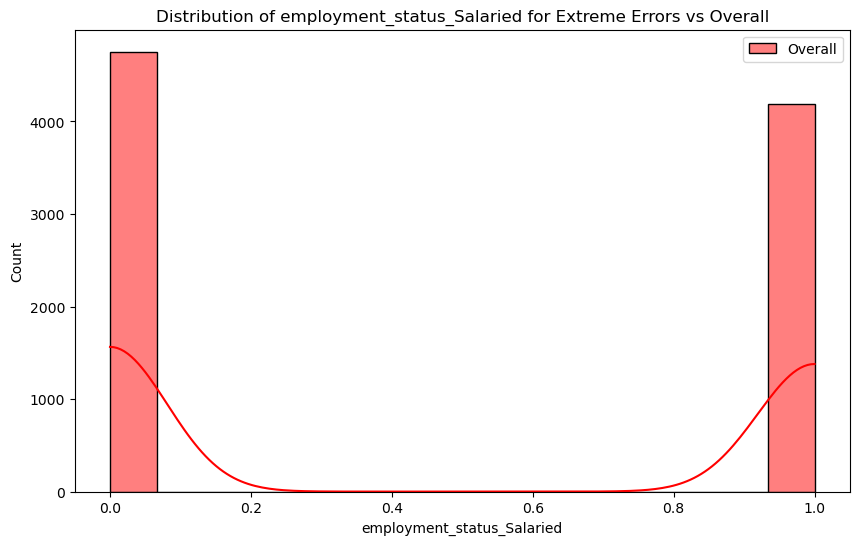

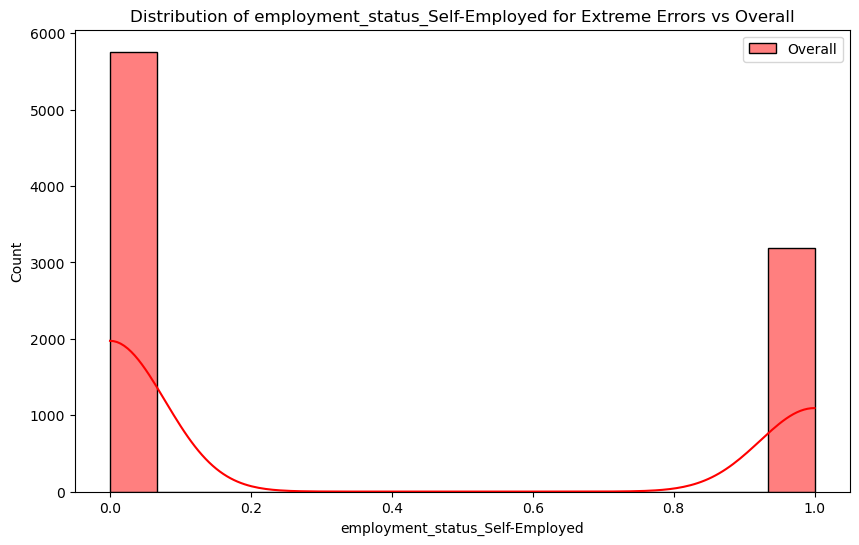

In [81]:
for feature in X.columns:
    plt.figure(figsize=(10,6))
    sns.histplot(X_test[feature],color = 'red',label='Overall',kde=True)
    sns.histplot(extreme_error_df[feature],label='Extreme Errors',kde=True)
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.legend()
    plt.show()

In [82]:
cols_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [83]:
df_reversed = pd.DataFrame()
df_reversed[cols_scale] = scaler.inverse_transform(extreme_error_df[cols_scale])

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

In [ ]:
df_reversed.head()

In [ ]:
sns.histplot(df_reversed['age'])

In [ ]:
df_reversed.describe()

In [84]:
#this shoes that 99% in the extreme error margin contains age grp which is less than age 25
df_reversed['age'].quantile(0.99)

KeyError: 'age'

# Model Segmentation